## Image Consistency Project 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import keras
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

In [3]:
## Dataset paths

token_path = "data/flickr/Flickr8k.token.txt"
train_images_path = 'data/flickr/Flickr_8k.trainImages.txt'
valid_images_path = 'data/flickr/Flickr_8k.devImages.txt'
test_images_path = 'data/flickr/Flickr_8k.testImages.txt'
images_path = 'data/flickr/Images/'
glove_path = 'data/glove.6B.200d.txt'

### Loading Image Filenames and it's corresponding Captions

In [4]:
from dataloader import load_captions_into_dictonary, generate_negative_samples

images_to_captions = load_captions_into_dictonary(token_path)
dataset_df = generate_negative_samples(images_to_captions)

### Visualise image and its captions

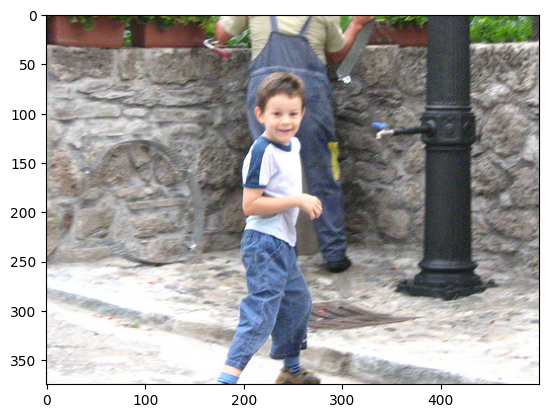

Consistent Captions of the image: ['a boy smiles in front of a stony wall in a city ', 'a little boy is standing on the street while a man in overalls is working on a stone wall ', 'a young boy runs aross the street ', 'a young child is walking on a stone paved street with a metal pole and a man behind him ', 'smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him ']


Inconsistent Captions of the image: ['a brown dog jumps high in the grass ', 'a man on top of a high mountain', 'an orange on the floor next to a dog ', 'a man is cycling on the road ', 'a winking boy in the snow wears a helmet and an orange ll bean jacket ']


In [5]:
## Visualise an Image and Captions

index = 8
image_path = os.path.join(images_path,dataset_df.iloc[index]['image_file'])
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()

postive_captions = dataset_df.iloc[index]['positive_captions']
negative_captions = dataset_df.iloc[index]['negative_captions']

print("Consistent Captions of the image:", postive_captions)
print("\n")
print("Inconsistent Captions of the image:", negative_captions)

### Getting embeddings of captions from glove

In [6]:
from generate_embeddings import *

vocab = get_vocab(dataset_df)
vocab_size = len(vocab) + 1
max_sen_length = max_sentence_length(dataset_df)
word_to_indices = get_word_indices(vocab)
embedding_matrix = get_embedding_matrix(glove_path, len(vocab)+1, word_to_indices)

### Generating train, valid and test datasets

In [7]:
from data_generator import *

train_dataset = DataGenerator(dataset_df, images_path, train_images_path, word_to_indices, max_sen_length)
valid_dataset = DataGenerator(dataset_df, images_path, valid_images_path, word_to_indices, max_sen_length)
test_dataset  = DataGenerator(dataset_df, images_path, test_images_path,  word_to_indices, max_sen_length)

In [8]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

6000
1000
1000


## Training the model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
check_point = ModelCheckpoint("Caption.h5", 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              save_weights_only=False, 
                              mode='auto', 
                              save_freq=1)

In [11]:
from model import image_caption_consistency_model

tf.get_logger().setLevel('ERROR')

epochs = 30
batch_size = 4
steps = len(train_dataset)//batch_size
val_steps = len(valid_dataset)//batch_size

model = image_caption_consistency_model(max_sen_length, vocab_size, embedding_matrix)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_dataset, 
                epochs=30, 
                steps_per_epoch=steps, 
                validation_data=valid_dataset, 
                validation_steps=val_steps, 
                shuffle=True, 
                callbacks=[early_stopping, check_point],
                verbose=1)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 38)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 38, 200)              391200    ['input_5[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 2048)                 0         ['input_4[0][0]']             
                                                                                            

In [12]:
model.save("Captions.h5")

/Users/muthyala.pragna/Library/Python/3.8/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
model_path = "Captions.h5"
model = keras.models.load_model(model_path)

## Testing the model

In [19]:
model.evaluate(test_dataset)

1000/1000 [==============================] - 66s 65ms/step - loss: 0.3279 - accuracy: 0.8606


[0.3279414772987366, 0.8605999946594238]

In [25]:
from sklearn.metrics import precision_score, recall_score

true_labels = []
pred_labels = []
for test in test_dataset:
    image_features = test[0][0]
    caption_seq = test[0][1]
    true_labels.extend(test[1])
    pred_labels.extend([1 if i>=0.5 else 0 for i in model.predict(test[0], verbose=0)])

precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1_score = 2*precision*recall/(precision+recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.8202486678507993
Recall: 0.9236
F1 Score: 0.8688617121354656


In [26]:
from image_encoding_model import image_encoder
from generate_embeddings import get_indices_of_captions

def predict_consistency(model, image_filepath, caption):
    img_features = image_encoder(image_filepath)
    cap_indices = get_indices_of_captions(caption, word_to_indices, max_sen_length)

    img_features = np.array([img_features])
    cap_indices = np.array([cap_indices])

    output = model.predict([img_features, cap_indices], verbose=0)[0][0]
    return output

#### Visualise Image and the output

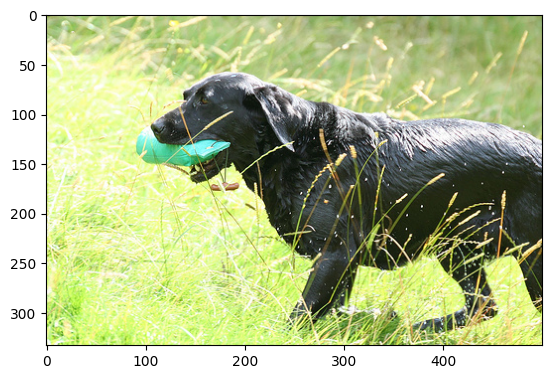

Caption: black dog walking on the grass
Model predicted consistency between image and caption: 0.9115844




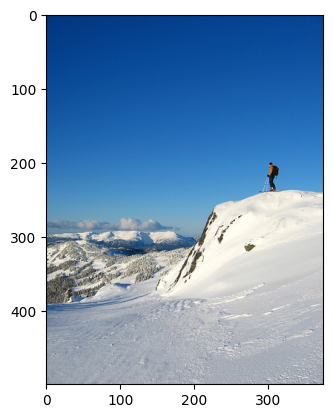

Caption: black dog walking the grass
Model predicted consistency between image and caption: 5.994192e-06




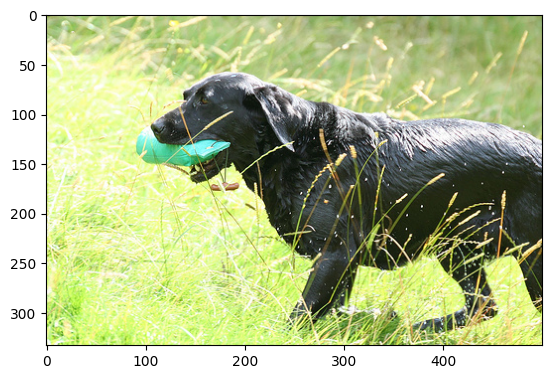

Caption: white dog on snow
Model predicted consistency between image and caption: 0.37429112


In [39]:
## Example outputs

image_filepath = os.path.join(images_path, dataset_df.iloc[22]['image_file'])
caption = "black dog walking on the grass"
consistency_value = predict_consistency(model, image_filepath, caption)
img = mpimg.imread(image_filepath)
imgplot = plt.imshow(img)
plt.show()
print("Caption:", caption)
print("Model predicted consistency between image and caption:", consistency_value)

print("\n")

image_filepath = os.path.join(images_path, dataset_df.iloc[49]['image_file'])
caption = "black dog walking the grass"
consistency_value = predict_consistency(model, image_filepath, caption)
img = mpimg.imread(image_filepath)
imgplot = plt.imshow(img)
plt.show()
print("Caption:", caption)
print("Model predicted consistency between image and caption:", consistency_value)

print("\n")

image_filepath = os.path.join(images_path, dataset_df.iloc[22]['image_file'])
caption = "white dog on snow"
consistency_value = predict_consistency(model, image_filepath, caption)
img = mpimg.imread(image_filepath)
imgplot = plt.imshow(img)
plt.show()
print("Caption:", caption)
print("Model predicted consistency between image and caption:", consistency_value)